# DCGAN - PyTorch using MNIST

### 작성자: 고려대학교 수학과 석사과정 최선묵

[References]  
- [Goodfellow's GAN Paper Link](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)  
- [DCGAN Paper Link](https://arxiv.org/pdf/1511.06434.pdf)


## Preparation

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import ReLU, LeakyReLU, Reshape
from tensorflow.keras.layers import BatchNormalization, Flatten

from tensorflow.keras.models import Model

from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.optimizers import Adam

## Data Preparation

In [3]:
def load_real_image(batch_size=32):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
    
    # Add the color channel - change to 4D tensor, and convert the data type to 'float32'
    train_images = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
    
    # Set the pixel values from -1 to 1
    train_images = (train_images/255.0) * 2 - 1
    
    # Shuffle and separate in batch
    buffer_size = train_images.shape[0]
    train_images_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
    
    return train_images_dataset


### Hyperparameters for latent codes

In [4]:
# Noise
noise_dim = 62

## Generator

In [5]:
def create_generator(n_filters=128, input_size=noise_dim):
    # Build functional API model
    # input
    input_tensor = Input(shape=(input_size, ))

    # Fully-connected layer.
    x = Dense(units=1024, use_bias=False, kernel_initializer='he_uniform') (input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Fully-connected layer. The output should be able to reshape into 7x7
    x = Dense(units=7*7*128, use_bias=False, kernel_initializer='he_uniform') (x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Reshape
    x = Reshape(target_shape=(7, 7, 128))(x)

    nf = n_filters
    # First transposed convolutional layer

    x = Conv2DTranspose(nf, kernel_size=(4, 4), strides=(2, 2), padding='same', 
                        use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Number of filters halved after each transposed convolutional layer
    nf = nf//2
    
    # Second transposed convolutional layer
    # strides=(2, 2): shape is doubled after the transposed convolution
    x = Conv2DTranspose(nf, kernel_size=(4, 4), strides=(2, 2), padding='same', 
                        use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Final transposed convolutional layer: output shape: 28x28x1, tanh activation
    output = Conv2DTranspose(1, kernel_size=(4, 4), strides=(1, 1), padding="same", 
                             activation="tanh", kernel_initializer='glorot_uniform')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    return model

In [6]:
g_model = create_generator()
g_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              63488     
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              6422528   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 6272)              0     

## Discriminator

In [7]:
def create_discriminator(n_filters=64, input_shape=(28, 28, 1)):
    # Build functional API model
    # Image Input
    image_input = Input(shape=input_shape)

    nf = n_filters
    
    x = Conv2D(nf, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=True)(image_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Number of filters doubled after each convolutional layer
    nf = nf*2
    
    # Second convolutional layer
    # Output shape: 7x7
    x = Conv2D(nf, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Flatten the convolutional layers
    x = Flatten()(x)

    # FC layer
    x = Dense(1024, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    # Discriminator output. Sigmoid activation function to classify "True" or "False"
    output = Dense(1, activation='sigmoid')(x)

    # Discriminator model (not compiled)
    d_model = Model(inputs=image_input, outputs=output)
    
    return d_model

In [8]:
d_model = create_discriminator()
d_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1088      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         131072    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0   

In [9]:
class GAN(tf.keras.Model):
    def __init__(self, d_model, g_model, noise_size=noise_dim, d_iter=1, seed=None):
        super(GAN, self).__init__()
        self.d_model = d_model
        self.g_model = g_model
        self.noise_size = noise_size
        self.d_iter = d_iter
        self.seed = seed

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def create_gen_input(self, batch_size, seed):
        noise = tf.random.normal([batch_size, self.noise_size], seed=seed)
        return noise

    def train_step(self, real_image_batch):
        
        # Define loss functions
        binary_loss = BinaryCrossentropy()
#         categorical_loss = CategoricalCrossentropy()
        
        # Half-batch for training discriminator and batch for training generator and auxiliary model
        batch_size = tf.shape(real_image_batch)[0]
        
        # Create generator input 
        g_noise = self.create_gen_input(batch_size=batch_size, seed=self.seed)
#         g_input = self.concat_inputs([g_cat, g_conti, g_noise])
        
        for _ in range(self.d_iter):
            with tf.GradientTape() as d_tape: 
                self.d_model.trainable = True
                d_tape.watch(self.d_model.trainable_variables)

                # Train discriminator using half batch real images. Real images have labels 1.
                y_disc_real = tf.ones((batch_size, 1))
                d_real_output = self.d_model(real_image_batch, training=True)
                d_loss_real = binary_loss(y_disc_real, d_real_output)

                # Train discriminator using half batch fake images. Fake images have labels 0. 
                y_disc_fake = tf.zeros((batch_size, 1))

                # Create fake image batch
                fake_image_batch = self.g_model(g_noise, training=True)
                d_fake_output = self.d_model(fake_image_batch, training=True)
                d_loss_fake = binary_loss(y_disc_fake, d_fake_output)

                # Total Loss of Discriminator 
                d_loss = d_loss_real + d_loss_fake

            # Calculate gradients
            d_gradients = d_tape.gradient(d_loss, self.d_model.trainable_variables)

            # Optimize
            self.d_optimizer.apply_gradients(zip(d_gradients, self.d_model.trainable_variables))

        with tf.GradientTape() as g_tape:
            # Create generator input 
            g_noise = self.create_gen_input(batch_size=batch_size*2, seed=self.seed)
            
            g_tape.watch(self.g_model.trainable_variables)
            
            # Create fake image batch
            fake_image_batch = self.g_model(g_noise, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            
            # Generator Image loss
            y_gen_fake = tf.ones((batch_size*2, 1))
            
            g_loss = binary_loss(y_gen_fake, d_fake_output)
            
            
        # Calculate gradients
        # We do not want to modify the neurons in the discriminator when training the generator and the auxiliary model
        self.d_model.trainable=False
        g_gradients = g_tape.gradient(g_loss, self.g_model.trainable_variables)
        
        # Optimize
        self.g_optimizer.apply_gradients(zip(g_gradients, self.g_model.trainable_variables))

        return {"d_loss_real": d_loss_real, "d_loss_fake": d_loss_fake, "g_loss": g_loss}

In [10]:
gan = GAN(d_model, g_model)

gan.compile(d_optimizer=Adam(learning_rate=2e-4),
            g_optimizer=Adam(learning_rate=5e-4))

real_images = load_real_image(batch_size=32)

history = gan.fit(real_images, epochs=80)

Epoch 1/80
1875/1875 [==============================] - 33s 11ms/step - d_loss_real: 0.1397 - d_loss_fake: 0.1960 - g_loss: 2.7078
Epoch 2/80
1875/1875 [==============================] - 21s 11ms/step - d_loss_real: 0.1199 - d_loss_fake: 0.1126 - g_loss: 3.6948
Epoch 3/80
1875/1875 [==============================] - 21s 11ms/step - d_loss_real: 0.4299 - d_loss_fake: 0.4106 - g_loss: 1.7906
Epoch 4/80
1875/1875 [==============================] - 21s 11ms/step - d_loss_real: 0.6156 - d_loss_fake: 0.6072 - g_loss: 0.9320
Epoch 5/80
1875/1875 [==============================] - 21s 11ms/step - d_loss_real: 0.6238 - d_loss_fake: 0.6181 - g_loss: 0.8991
Epoch 6/80
1875/1875 [==============================] - 21s 11ms/step - d_loss_real: 0.6195 - d_loss_fake: 0.6153 - g_loss: 0.9038
Epoch 7/80
1875/1875 [==============================] - 21s 11ms/step - d_loss_real: 0.6066 - d_loss_fake: 0.6039 - g_loss: 0.9338
Epoch 8/80
1875/1875 [==============================] - 21s 11ms/step - d_loss_real

In [11]:
g_model.save('saved_models/generator')
d_model.save('saved_models/discriminator')

INFO:tensorflow:Assets written to: saved_models/generator/assets
INFO:tensorflow:Assets written to: saved_models/discriminator/assets


In [12]:
g_model = tf.keras.models.load_model('saved_models/generator')
d_model = tf.keras.models.load_model('saved_models/discriminator')

## Test

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
noise = tf.random.normal([10, 62], seed=831)

x = g_model(noise)

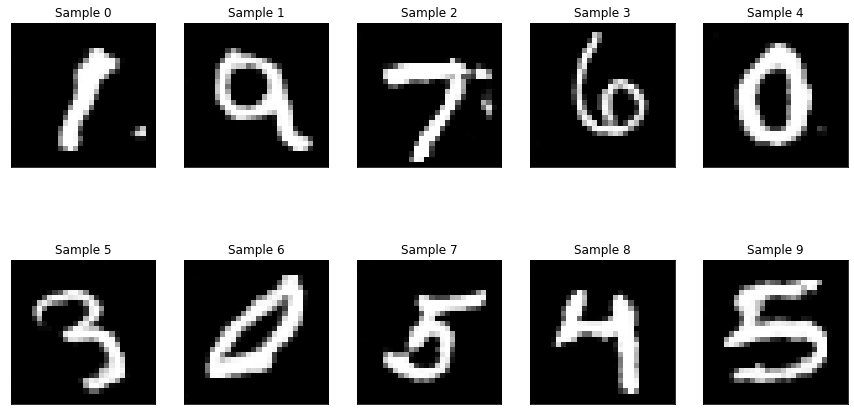

In [17]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)

rows = 2
columns = 5

for i in range(10) : 
    image_index = i      # image index 
    title = "Sample {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index+1) # subplot 
    plt.title(title)   # title 
    # // plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(x[i], cmap=plt.get_cmap('gray'))  
plt.show()
